In [3]:
# ============================
# 1. Mount Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

# ============================
# 2. Paths and setup
# ============================
import os, random, math, shutil, pathlib

DATASET_PATH = "/content/drive/MyDrive/Research/archive/cell_images/cell_images"   # <-- change if needed
WORK_DIR = "/content/malaria_subset"
os.makedirs(WORK_DIR, exist_ok=True)

classes = ["Parasitized", "Uninfected"]

# ============================
# 3. Create 1000-image subset (500 per class)
# ============================
files_by_class = {}
for cls in classes:
    cls_dir = pathlib.Path(DATASET_PATH) / cls
    files = [str(p) for p in cls_dir.glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]]
    random.shuffle(files)
    files_by_class[cls] = files[:500]  # cap at 500

# Split 70/15/15
splits = {"train": 0.7, "val": 0.15, "test": 0.15}
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(WORK_DIR, split, cls), exist_ok=True)

for cls in classes:
    files = files_by_class[cls]
    n = len(files)
    n_train = math.floor(n * splits["train"])
    n_val = math.floor(n * splits["val"])
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for f in train_files:
        shutil.copy(f, os.path.join(WORK_DIR, "train", cls, os.path.basename(f)))
    for f in val_files:
        shutil.copy(f, os.path.join(WORK_DIR, "val", cls, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(WORK_DIR, "test", cls, os.path.basename(f)))

print("Subset created at:", WORK_DIR)

# ============================
# 4. tf.data pipeline
# ============================
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(split):
    ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(WORK_DIR, split),
        labels="inferred",
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=(split == "train"),
    )
    return ds

train_ds = make_ds("train")
val_ds   = make_ds("val")
test_ds  = make_ds("test")

# Augmentation + preprocessing
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
], name="augment")

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1024)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds, training=False)
test_ds  = prepare(test_ds, training=False)

# ============================
# 5A. Small CNN from scratch
# ============================
from tensorflow import keras
from tensorflow.keras import layers

def build_small_cnn(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

cnn_model = build_small_cnn()
cnn_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")])

cnn_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_acc"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
]

cnn_history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=cnn_callbacks)

# ============================
# 5B. MobileNetV2 Transfer Learning (recommended)
# ============================
base = keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
base.trainable = False

inputs = keras.Input(shape=(224,224,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")])

warmup = model.fit(train_ds, validation_data=val_ds, epochs=5,
                   callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_acc")])

# Fine-tune last layers
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")])

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_acc"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

# ============================
# 6. Evaluation
# ============================
test_metrics = model.evaluate(test_ds)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

import numpy as np
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.concatenate([model.predict(x).ravel() for x, _ in test_ds], axis=0)
y_hat = (y_pred >= 0.5).astype(int)
acc = (y_hat == y_true).mean()
print(f"Thresholded test accuracy: {acc:.4f}")

# ============================
# 7. Save model
# ============================
model.save("/content/malaria_model_mobilenetv2.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Subset created at: /content/malaria_subset
Found 700 files belonging to 2 classes.
Found 150 files belonging to 2 classes.
Found 150 files belonging to 2 classes.
Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - acc: 0.4956 - auc: 0.4868 - loss: 0.7009 - val_acc: 0.6400 - val_auc: 0.6881 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - acc: 0.5954 - auc: 0.6335 - loss: 0.6801 - val_acc: 0.6200 - val_auc: 0.7593 - val_loss: 0.6331 - learning_rate: 0.0010
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - acc: 0.6686 - auc: 0.7061 - loss: 0.6509 - val_acc: 0.7067 - val_auc: 0.7941 - val_loss: 0.6227 - learning_rate: 0.0010
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - acc: 0.7324 - auc: 0.8035 - loss: 0.5902 - val_acc: 0.8067 - val_auc: 0.8792 - val_loss: 0.4984 - learning_rate: 0.0010
Epoch 5/25
22/22

Thresholded test accuracy: 0.5000


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step

=== Classification Report ===
              precision    recall  f1-score   support

 Parasitized       0.93      0.91      0.92        75
  Uninfected       0.91      0.93      0.92        75

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



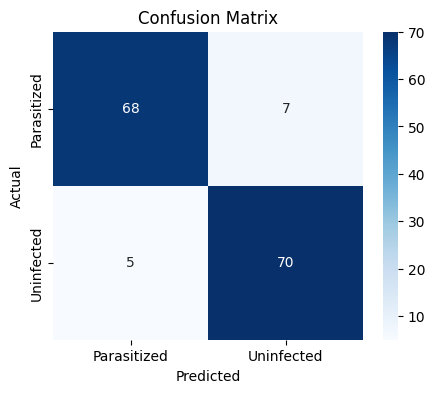

<Figure size 640x480 with 0 Axes>

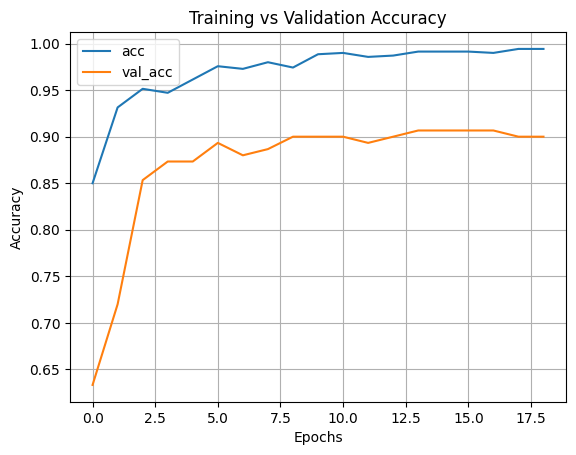

<Figure size 640x480 with 0 Axes>

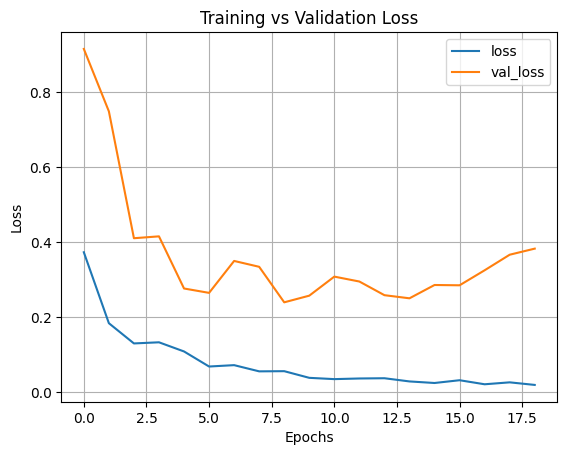

In [5]:
# ============================
# Evaluation & Visualization
# ============================
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Convert test dataset into Numpy arrays
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.concatenate([model.predict(x).ravel() for x, _ in test_ds], axis=0)
y_hat = (y_pred >= 0.5).astype(int)

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_true, y_hat, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_hat)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy & Loss Curves From History
history_df = pd.DataFrame(history.history)

plt.figure()
history_df[['acc', 'val_acc']].plot()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure()
history_df[['loss', 'val_loss']].plot()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()